In [1]:
import git
root = git.Repo('.', search_parent_directories=True).working_dir 

import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
order_train = pl.scan_parquet(f'{root}/data/orders').drop('created_date')
order_extra = pl.scan_parquet(f'{root}/data/extra_orders')

order = pl.concat([order_train, order_extra])

In [3]:
orders_by_dt = (
    order
    .group_by(
        pl.col('created_timestamp').dt.strftime('%Y-%m-%d'),
        'last_status'
    )
    .agg(pl.len())
    .collect()
    .to_pandas()
)

orders_by_dt['created_timestamp'] = pd.to_datetime(orders_by_dt['created_timestamp']) 

orders_by_dt.head()

,created_timestamp,last_status,len
0,2025-05-01,proccesed_orders,807
1,2025-01-07,proccesed_orders,491
2,2025-03-10,canceled_orders,48669
3,2025-02-15,proccesed_orders,501
4,2025-01-19,delivered_orders,44345


<Axes: xlabel='created_timestamp', ylabel='len'>

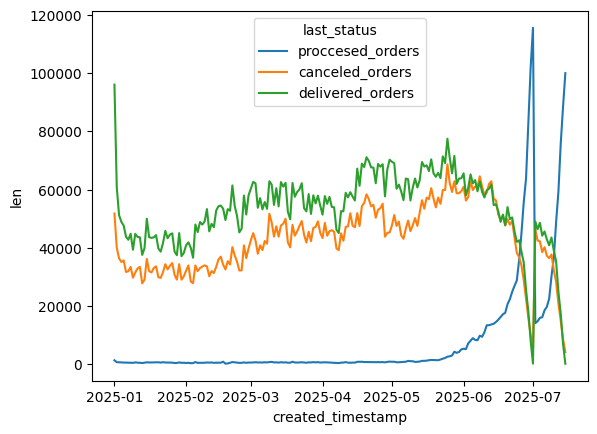

In [4]:
sns.lineplot(data=orders_by_dt, x='created_timestamp', y='len', hue='last_status')

<Axes: xlabel='created_timestamp', ylabel='len'>

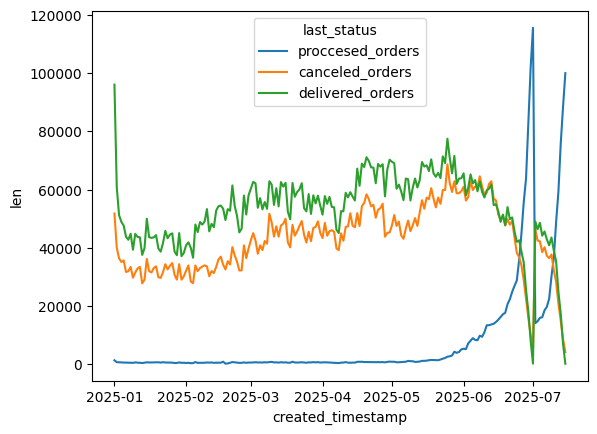

In [5]:
sns.lineplot(data=orders_by_dt, x='created_timestamp', y='len', hue='last_status')

In [6]:
orders_by_dt = (
    order
    .select(
        pl.col('last_status'),
        ((pl.col('last_status_timestamp') - pl.col('created_timestamp')).alias('days_btw')).dt.total_days()
    )
    .collect()
)

orders_by_dt.group_by('last_status').agg(pl.mean('days_btw'))

last_status,days_btw
str,f64
"""proccesed_orders""",0.109286
"""canceled_orders""",8.122288
"""delivered_orders""",6.630331


In [30]:
days_status = orders_by_dt.filter(pl.col('last_status') != 'proccesed_orders').to_pandas().groupby('days_btw').last_status.value_counts(normalize=True).reset_index()

In [34]:
days_status

,days_btw,last_status,proportion
0,0,canceled_orders,0.644923
1,0,delivered_orders,0.355077
2,1,delivered_orders,0.963202
3,1,canceled_orders,0.036798
4,2,delivered_orders,0.893516
...,...,...,...
272,173,canceled_orders,1.000000
273,175,canceled_orders,1.000000
274,176,canceled_orders,1.000000
275,178,canceled_orders,1.000000


<Axes: xlabel='days_btw', ylabel='proportion'>

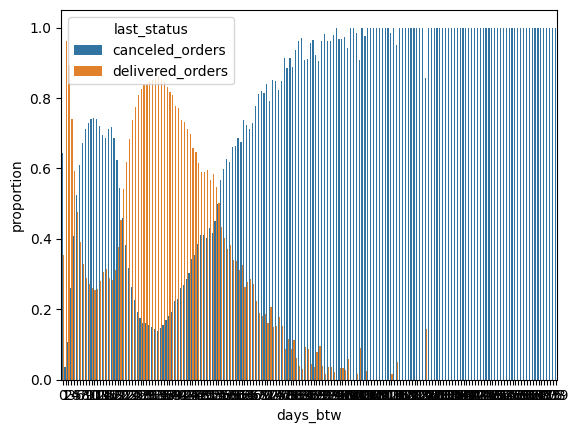

In [35]:
sns.barplot(data=days_status, x='days_btw', y='proportion', hue='last_status')

In [7]:
status = ["proccesed_orders", "delivered_orders", "canceled_orders"]

status_count = [
    pl.col('last_status')
    .filter(pl.col('last_status') == status)
    .count()
    .alias(status) 
    for status in status
]

df = (
    order
    .group_by('user_id', 'item_id')
    .agg(*status_count)
    .collect()
    .to_pandas()
)

df.head()

,user_id,item_id,proccesed_orders,delivered_orders,canceled_orders
0,3088180,302319336,0,1,0
1,2942730,39046785,0,1,0
2,3796871,334443483,0,1,0
3,2814630,81710677,0,1,0
4,4007451,312010693,0,1,0


In [8]:
df[['proccesed_orders', 'delivered_orders', 'canceled_orders']].corr(method='spearman')

,proccesed_orders,delivered_orders,canceled_orders
proccesed_orders,1.000000,-0.292351,-0.217185
delivered_orders,-0.292351,1.000000,-0.813536
canceled_orders,-0.217185,-0.813536,1.000000


In [9]:
(df[['proccesed_orders', 'delivered_orders', 'canceled_orders']] != 0).value_counts().sort_index()

proccesed_orders  delivered_orders  canceled_orders
False             False             True               7620088
                  True              False              9788689
                                    True                287427
True              False             False              1404896
                                    True                 57667
                  True              False                25094
                                    True                  4992
Name: count, dtype: int64

<Axes: xlabel='canceled_orders', ylabel='delivered_orders'>

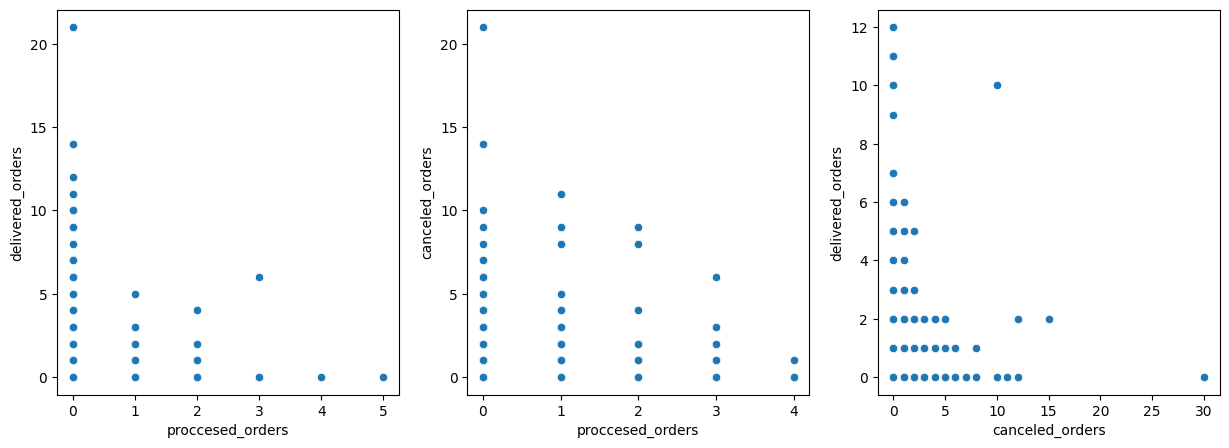

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

sns.scatterplot(data=df.sample(100000), x='proccesed_orders', y='delivered_orders', ax=ax[0])
sns.scatterplot(data=df.sample(100000), x='proccesed_orders', y='canceled_orders', ax=ax[1])
sns.scatterplot(data=df.sample(100000), x='canceled_orders', y='delivered_orders', ax=ax[2])

In [11]:
df['delivered_ratio'] = df['delivered_orders'] / (df['delivered_orders'] + df['canceled_orders'])

In [12]:
df.sort_values('canceled_orders', ascending=False).head(100)

,user_id,item_id,proccesed_orders,delivered_orders,canceled_orders,delivered_ratio
6270135,2008200,4762830,0,0,301,0.0
3674715,808380,116701227,0,0,209,0.0
11488271,808380,191658944,0,0,201,0.0
10371474,808380,158677086,0,0,199,0.0
853134,983120,44101421,0,0,175,0.0
...,...,...,...,...,...,...
9998573,828841,106660865,0,0,25,0.0
13113243,352381,87177567,0,0,24,0.0
7273598,2779651,153677259,0,0,24,0.0
11605610,1874041,188215946,0,0,24,0.0


In [13]:
df.sort_values('delivered_orders', ascending=False).head(100)

,user_id,item_id,proccesed_orders,delivered_orders,canceled_orders,delivered_ratio
1050969,3474130,224605809,0,206,0,1.0
6567344,3874681,17922795,0,120,0,1.0
1040986,3393841,18226007,0,120,0,1.0
19143454,1768450,277136832,0,110,0,1.0
13248634,1290650,220300905,0,103,0,1.0
...,...,...,...,...,...,...
10417779,1783730,155594562,0,30,0,1.0
14618365,1095991,332709634,0,30,0,1.0
7356868,4078900,91044915,0,30,0,1.0
9248025,4500621,259340748,0,30,0,1.0


In [14]:
df.sort_values('proccesed_orders', ascending=False).head(100)

,user_id,item_id,proccesed_orders,delivered_orders,canceled_orders,delivered_ratio
6274490,1797481,164229876,165,0,0,NaN
6199655,1759320,149073496,81,0,0,NaN
2823312,2964851,22097010,31,0,0,NaN
10123975,224151,275259738,26,0,0,NaN
16076629,4920020,310847285,20,0,0,NaN
...,...,...,...,...,...,...
4286473,615101,125533233,6,1,4,0.2
16902450,3918511,339214404,6,0,0,NaN
3478673,392771,29529313,6,0,0,NaN
1052065,4104071,2626778,6,0,0,NaN


In [15]:
order.filter((pl.col('user_id') == 1797481) & (pl.col('item_id') == 164229876)).collect().to_pandas().sort_values('created_timestamp')

,item_id,user_id,created_timestamp,last_status,last_status_timestamp
94,164229876,1797481,2025-06-30 16:03:09.303,proccesed_orders,2025-06-30 16:35:58
143,164229876,1797481,2025-06-30 16:03:55.293,proccesed_orders,2025-06-30 16:35:33
46,164229876,1797481,2025-06-30 16:04:08.960,proccesed_orders,2025-06-30 16:35:46
122,164229876,1797481,2025-06-30 16:04:28.030,proccesed_orders,2025-06-30 16:35:58
106,164229876,1797481,2025-06-30 16:04:40.823,proccesed_orders,2025-06-30 16:36:02
...,...,...,...,...,...
114,164229876,1797481,2025-06-30 16:46:02.950,proccesed_orders,2025-06-30 17:08:12
127,164229876,1797481,2025-06-30 16:46:12.340,proccesed_orders,2025-06-30 17:08:05
24,164229876,1797481,2025-06-30 16:46:43.776,proccesed_orders,2025-06-30 17:23:27
11,164229876,1797481,2025-06-30 16:46:56.130,proccesed_orders,2025-06-30 17:23:27


<Axes: xlabel='delivered_ratio', ylabel='Count'>

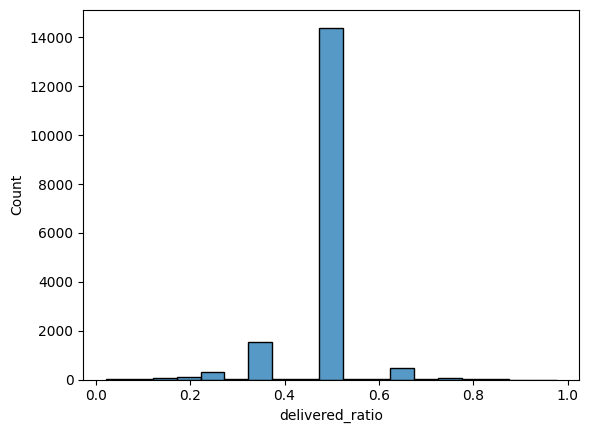

In [16]:
sns.histplot(df.loc[~df['delivered_ratio'].isin([1, 0]), 'delivered_ratio'].sample(100000), binwidth=0.05)

<Axes: xlabel='delivered_ratio', ylabel='Count'>

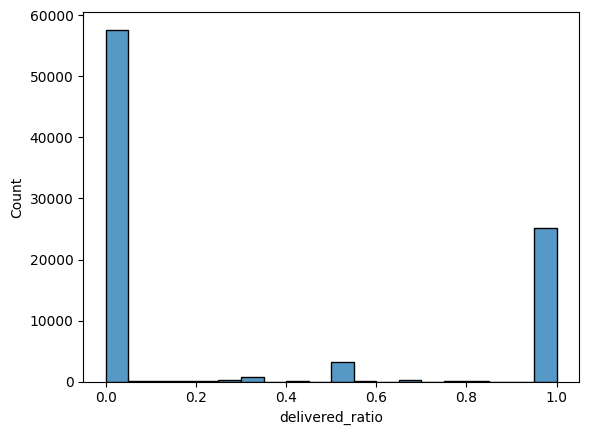

In [17]:
sns.histplot(df.loc[(df['proccesed_orders'] > 0), 'delivered_ratio'], binwidth=0.05)

<Axes: xlabel='delivered_ratio', ylabel='Count'>

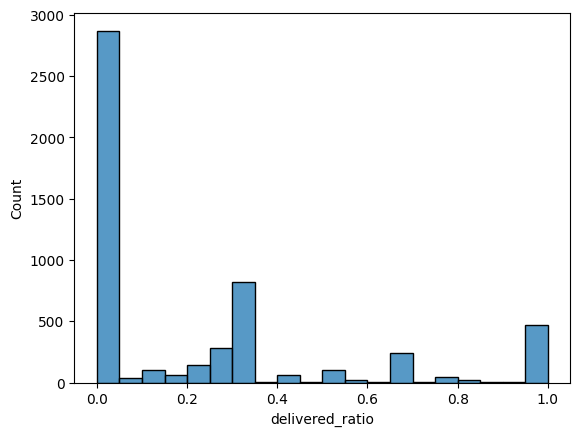

In [18]:
sns.histplot(df.loc[((df['delivered_orders'] + df['canceled_orders']) > 2) & (df['proccesed_orders'] > 0), 'delivered_ratio'], binwidth=0.05)

In [19]:
user_df = df.groupby('user_id')[status].sum().sort_values('canceled_orders')
user_df

,proccesed_orders,delivered_orders,canceled_orders
user_id,,,
4634051,0,1,0
4634020,0,6,0
110,1,7,0
4634190,0,1,0
4634141,1,1,0
...,...,...,...
4430170,24,94,1144
3071530,33,42,1342
3892430,159,451,1377


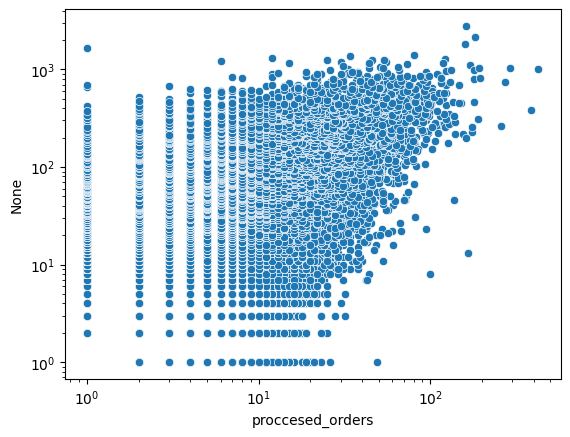

In [25]:
sns.scatterplot(x=user_df['proccesed_orders'] + 1, y=(user_df['delivered_orders'] + user_df['canceled_orders'] + 1))
plt.xscale('log')
plt.yscale('log')

In [21]:
item_df = df.groupby('item_id')[status].sum().sort_values('delivered_orders')
item_df

,proccesed_orders,delivered_orders,canceled_orders
item_id,,,
113697521,0,0,1
113697139,0,0,1
113697088,1,0,0
113699886,0,0,1
113699597,0,0,3
...,...,...,...
119105606,171,3036,290
143497612,36,3920,140
207631139,1179,5596,2102


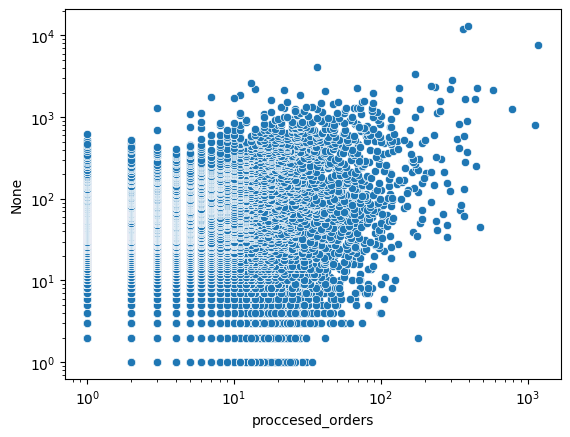

In [24]:
sns.scatterplot(x=item_df['proccesed_orders'] + 1, y=(item_df['delivered_orders'] + item_df['canceled_orders'] + 1))
plt.xscale('log')
plt.yscale('log')

- Delivered multiple and similar, chose only one; Others rejected
- Take mix of item and user specific data.